## University of Melbourne Grant Predictions

In [19]:
# Modified Kaggle competition solution for further interpretation

# Link to Kaggle competition:  https://www.kaggle.com/c/unimelb/overview
# Link to Kaggle solution:     https://www.kaggle.com/irinana/predict-graint

### Import Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

### Import Training and Test Data

In [21]:
data = pd.read_csv('unimelb_training.csv')
print(data.info())

test = pd.read_csv('unimelb_test.csv')
test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Columns: 252 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(2), object(70)
memory usage: 16.7+ MB
None


(2176, 252)

### Combine Train and Test, Drop Target Variable

In [22]:
X = pd.concat([data, test], ignore_index= 'True').drop('Grant.Status', 1)
y = data['Grant.Status']
X.info()

X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Columns: 251 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(1), object(70)
memory usage: 20.8+ MB


,Grant.Application.ID,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,Start.date,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,...,Faculty.No..15,With.PHD.15,No..of.Years.in.Uni.at.Time.of.Grant.15,Number.of.Successful.Grant.15,Number.of.Unsuccessful.Grant.15,A..15,A.15,B.15,C.15,Unnamed: 251
0,1,NaN,NaN,A,8/11/05,280199.0,100.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2B,10A,B,11/11/05,280103.0,30.0,280106.0,30.0,280203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,29A,10B,A,14/11/05,321004.0,60.0,321216.0,40.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,40D,10B,C,15/11/05,270602.0,50.0,320602.0,50.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,59C,10A,A,16/11/05,260500.0,34.0,280000.0,33.0,290000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define Categorical and Numerical Features

In [23]:
ind,numeric_cols = X.select_dtypes(exclude=['object']).axes

ind,categorical_cols = X.select_dtypes(include=['object']).axes

print(numeric_cols.shape, categorical_cols.shape)
print(numeric_cols)
X['RFCD.Percentage.1'].isnull().value_counts()

(181,) (70,)
Index(['Grant.Application.ID', 'RFCD.Code.1', 'RFCD.Percentage.1',
       'RFCD.Code.2', 'RFCD.Percentage.2', 'RFCD.Code.3', 'RFCD.Percentage.3',
       'RFCD.Code.4', 'RFCD.Percentage.4', 'RFCD.Code.5',
       ...
       'Dept.No..15', 'Faculty.No..15', 'With.PHD.15',
       'Number.of.Successful.Grant.15', 'Number.of.Unsuccessful.Grant.15',
       'A..15', 'A.15', 'B.15', 'C.15', 'Unnamed: 251'],
      dtype='object', length=181)


False    9839
True     1045
Name: RFCD.Percentage.1, dtype: int64

### Missing Value Imputation

In [24]:
# Fill na values with 0
X_real_zeros = X[numeric_cols].fillna(0.0)

"""X_real_mean = X[numeric_cols] 
for col in numeric_cols:
     X_real_mean[col]=X_real_mean[col].fillna(np.mean(X_real_mean[col]))"""
        
X_cat = X[categorical_cols].fillna('NA').astype(str)
print(X_cat.shape, X_real_zeros.shape)

(10884, 70) (10884, 181)


In [25]:
X['Year.of.Birth.1'].value_counts()

1965.0    1994
1960.0    1911
1970.0    1644
1955.0    1352
1975.0    1258
1950.0     960
1945.0     480
1980.0     411
1940.0     137
1935.0      21
1985.0      10
1930.0       6
1925.0       2
Name: Year.of.Birth.1, dtype: int64

In [26]:
# Percentages of grant application acceptances vs denials
y.value_counts()/len(y)

0    0.541571
1    0.458429
Name: Grant.Status, dtype: float64

## Personal Manipulation / Modification

250.0
325102.5


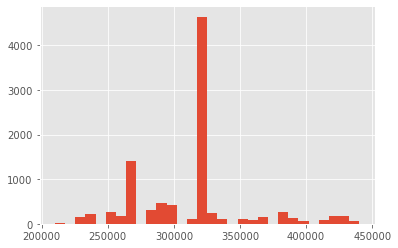

In [27]:
# Remove NaN values of RVCD.Code.1. This includes value of 999999
X_upd = X[X['RFCD.Code.1']!=999999]
hist = plt.hist(X_upd['RFCD.Code.1'], bins=30)
print(hist[0][15])
print(hist[1][15])

Here we can see the real distribution of RFCD.Code.1 in more detail. 

### One-Hot Encoding

In [28]:
# Encode categorical features
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

print (X_cat_oh.shape)

(10884, 1647)


array([[<AxesSubplot:xlabel='Number.of.Successful.Grant.1', ylabel='Number.of.Successful.Grant.1'>,
        <AxesSubplot:xlabel='SEO.Percentage.2', ylabel='Number.of.Successful.Grant.1'>,
        <AxesSubplot:xlabel='Year.of.Birth.1', ylabel='Number.of.Successful.Grant.1'>],
       [<AxesSubplot:xlabel='Number.of.Successful.Grant.1', ylabel='SEO.Percentage.2'>,
        <AxesSubplot:xlabel='SEO.Percentage.2', ylabel='SEO.Percentage.2'>,
        <AxesSubplot:xlabel='Year.of.Birth.1', ylabel='SEO.Percentage.2'>],
       [<AxesSubplot:xlabel='Number.of.Successful.Grant.1', ylabel='Year.of.Birth.1'>,
        <AxesSubplot:xlabel='SEO.Percentage.2', ylabel='Year.of.Birth.1'>,
        <AxesSubplot:xlabel='Year.of.Birth.1', ylabel='Year.of.Birth.1'>]],
      dtype=object)

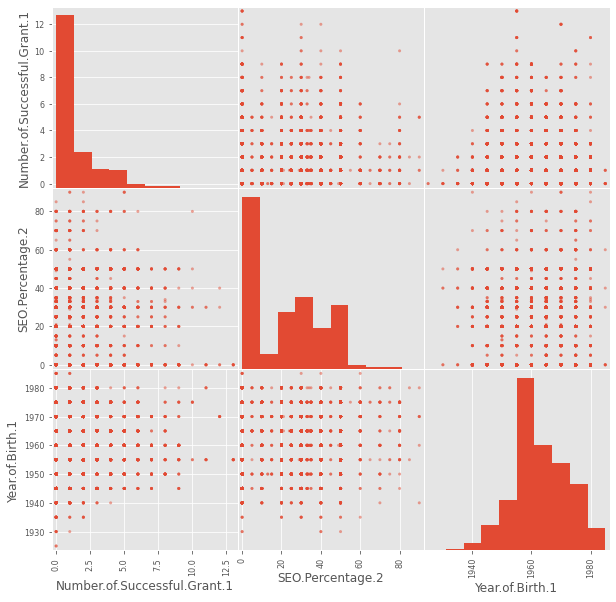

In [29]:
# Plot scatter matrix that contain own data cleaning methods, including removal of missing values
from pandas.plotting import scatter_matrix
list_cols = ['Number.of.Successful.Grant.1','SEO.Percentage.2','Year.of.Birth.1']
scatter_matrix(X[list_cols], figsize=(10,10))

Here, instead of visualizing the distribution with a histogram, I used the value counts to see the distribution. This was the end of my data manipulation and cleaning.

### Scaling Data

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real_zeros)

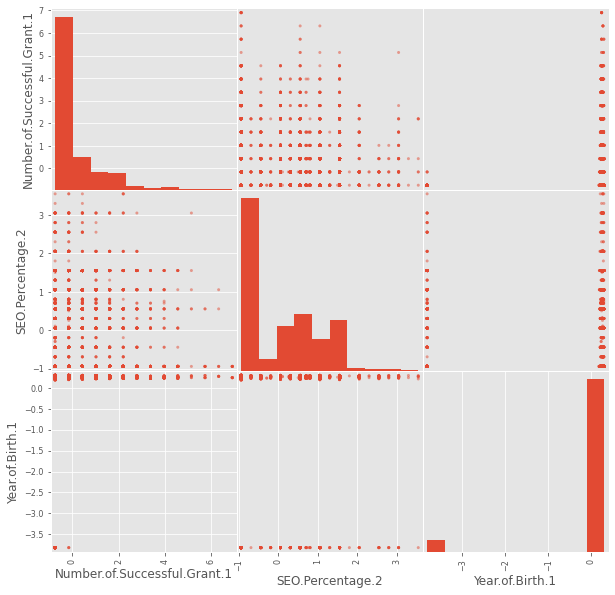

In [31]:
# Graphs for scaled data
data_numeric_scaled = pd.DataFrame(X_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Now, the models need to be trained and tuned.

### Collecting Data to Train the Model

In [32]:
test_zeros=np.hstack((X_real_zeros[8708:] , X_cat_oh[8708:]))
X_real_zeros_cut = X_real_zeros[:8708]
X_cat_oh_cut = X_cat_oh[:8708]

print(X_real_zeros.info())
print(test_zeros.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Columns: 181 entries, Grant.Application.ID to Unnamed: 251
dtypes: float64(180), int64(1)
memory usage: 15.0 MB
None
(2176, 1828)


In [33]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, X_test_real_zeros, y_train, y_test) = train_test_split(X_real_zeros_cut, y, test_size=0.3, stratify=y, random_state=0)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_oh_cut, test_size=0.3, random_state=0, stratify=y)
print(X_train_real_zeros.shape)
y_train.shape

(6095, 181)


(6095,)

In [34]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

3301
2794


### Parameter Tuning / Cross Validation

In [35]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

learn_zeros=np.hstack((X_train_real_zeros,X_train_cat_oh))
#learn_means=np.hstack((X_train_real_mean,X_train_cat_oh))

estimator_lasso = LogisticRegression (solver='liblinear',  class_weight='balanced', penalty = 'l1')
optimizer_zeros = GridSearchCV(estimator_lasso, param_grid,  cv=3, n_jobs=-1)                
optimizer_zeros.fit(learn_zeros, y_train)

#optimizer_means = GridSearchCV(estimator_lasso, param_grid,  cv=3, n_jobs=-1)                
#optimizer_means.fit(learn_means, y_train)

print('score_lasso', optimizer_zeros.best_score_)
print('param _lasso', optimizer_zeros.best_params_)
#print('score_zeros_Smb', optimizer_means.best_score_)

score_lasso 0.837571206018007
param _lasso {'C': 1}


### Plotting C Value vs Accuracy Score

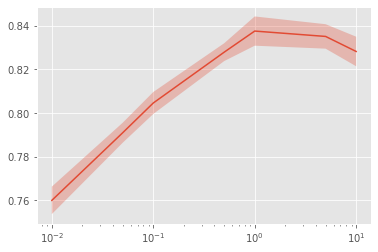

param _zeros_Smb {'C': 1}
1828
[[-2.48410574e-04  1.50569986e-07  4.17226909e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [36]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    print('param _zeros_Smb', optimizer.best_params_)

plot_scores(optimizer_zeros)
#plot_scores(optimizer_means)

coefficients = optimizer_zeros.best_estimator_.coef_
print(len(coefficients[0]))
print(coefficients)

### Plotting Predicted Probabilities

(array([420., 167.,  81.,  76.,  58.,  59.,  42.,  45.,  34.,  41.,  23.,
         33.,  30.,  23.,  24.,  28.,  25.,  25.,  28.,  30.,  20.,  26.,
         22.,  24.,  26.,  31.,  20.,  24.,  22.,  20.,  29.,  33.,  29.,
         22.,  36.,  34.,  40.,  37.,  35.,  25.,  25.,  31.,  26.,  19.,
         32.,  16.,  29.,  36.,  43.,  72.]),
 array([6.19504448e-14, 2.00000000e-02, 4.00000000e-02, 6.00000000e-02,
        8.00000000e-02, 1.00000000e-01, 1.20000000e-01, 1.40000000e-01,
        1.60000000e-01, 1.80000000e-01, 2.00000000e-01, 2.20000000e-01,
        2.40000000e-01, 2.60000000e-01, 2.80000000e-01, 3.00000000e-01,
        3.20000000e-01, 3.40000000e-01, 3.60000000e-01, 3.80000000e-01,
        4.00000000e-01, 4.20000000e-01, 4.40000000e-01, 4.60000000e-01,
        4.80000000e-01, 5.00000000e-01, 5.20000000e-01, 5.40000000e-01,
        5.60000000e-01, 5.80000000e-01, 6.00000000e-01, 6.20000000e-01,
        6.40000000e-01, 6.60000000e-01, 6.80000000e-01, 7.00000000e-01,
        7.

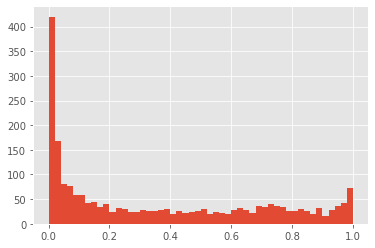

In [37]:
y_ans = optimizer_zeros.best_estimator_.predict_proba(test_zeros)[:,0]
Y = optimizer_zeros.best_estimator_.predict_proba(test_zeros)[:,0]
plt.hist(Y, bins=50)

In [38]:
y_binary = optimizer_zeros.best_estimator_.predict(test_zeros)
pos = np.sum(y_binary)
neg = len(y_binary) - pos
print("Successful outcomes: ", pos)
print("Unsuccessful outcomes: ",neg)

Successful outcomes:  1410
Unsuccessful outcomes:  766


## Nutritional Label:  Attribute Weights (Recipe)
- The recipe widget displays the attributes within the dataset that we chose to focus on and its corresponding weight or importance in the estimator.
- Focused on Country.of.Birth.1 column and the Home.Language.1 features.

In [39]:
# feature_names is a list of the feature names for each column in the one hot encoder
feature_names = encoder.feature_names_
country_indices = []
language_indices=[]

for i in range(len(feature_names)):
  # if the first several letters in the feature correspond to this 
  if feature_names[i][:19] == "Country.of.Birth.1=":
    # add the index to a list
    country_indices+=[i]


for i in range(len(feature_names)):
    if feature_names[i][:15] == "Home.Language.1":
        language_indices += [i]

In [40]:
country_weight = 0
for i in country_indices:
    print(optimizer_zeros.best_estimator_.coef_[0][i])
    country_weight += abs(optimizer_zeros.best_estimator_.coef_[0][i])
print("\nTotal weight of Country of Birth attribute: ", country_weight)

language_weight = 0
for i in language_indices:
    print(optimizer_zeros.best_estimator_.coef_[0][i])
    language_weight += abs(optimizer_zeros.best_estimator_.coef_[0][i])
print("\nTotal weight of Home Language attribute: ",language_weight)

0.18911486488603416
-0.1625839047707307
-0.027055529406358775
0.0
-0.06137707426297761
0.171372891313151
-1.2906499033135234e-06
-9.392001868018345e-05
8.654862739531754e-06
-0.006171782427799475
0.3156221370703379

Total weight of Country of Birth attribute:  0.9334020496687125
0.0
0.0
0.0
0.0
0.0
0.0

Total weight of Home Language attribute:  0.0


From this, we can see that the Country.of.Birth.1 attribute that we will use for all of our fairness metrics had an overall weight of 0.93 in the estimator. The Home.Language.1 attribute had a weight of 0 in the estimator. This means that the Country.of.Birth.1 column had a significant pull in the model’s estimations. However, the Home.Language.1 attribute did not.

### Add Necessary Columns
- GrantStatus is probability of Successful grant
- SuccessfulGrant is whether the grant was predicted successful or not
- NativeBirthCountry is if the person was born in New Zealand or Australia

In [41]:
# Add the predicted probabilities to the dataset and look at results across different subpopulations
# Compute mean Grant Status across entire datset

test['GrantStatus'] = Y
test['SuccessfulGrant'] = y_binary

In [42]:
# Add column for privileged groups and unprivileged groups
# Privileged is if country of birth is either australia or New Zealand
# Unprivileged is if country of birth is outside these regions

native=[]
for i in test['Country.of.Birth.1']:
    if i == 'Australia' or i=='New Zealand':
        native+=["Native"]
    else:
        native+=["Non-Native"]
test['NativeBirthCountry'] = native

### Visualize Results

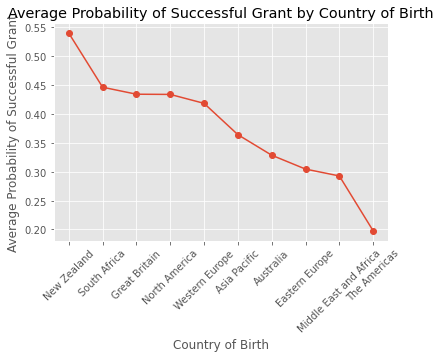

Country.of.Birth.1
Asia Pacific              0.363895
Australia                 0.328424
Eastern Europe            0.304433
Great Britain             0.433844
Middle East and Africa    0.292562
New Zealand               0.539397
North America             0.433504
South Africa              0.445949
The Americas              0.197699
Western Europe            0.418052
Name: GrantStatus, dtype: float64

In [43]:
plt.plot(test.groupby("Country.of.Birth.1")['GrantStatus'].mean().sort_values(ascending=False), marker="o", linestyle="solid")
plt.xticks(rotation=45)
plt.xlabel('Country of Birth')
plt.ylabel("Average Probability of Successful Grant")
plt.title("Average Probability of Successful Grant by Country of Birth")
plt.show()
test.groupby("Country.of.Birth.1")['GrantStatus'].mean()

## Nutritional Label: Feature Summary (Ingredients)
- Ingredients widget contained the numbers of successful grants in each of the features that we investigated: Country of Birth and Home Language.

In [44]:
engdf = test.groupby("Home.Language.1")['SuccessfulGrant'].sum()
df = test.groupby("Country.of.Birth.1")['SuccessfulGrant'].sum()

stats = [[df.min(), df.max(), df.mean(), df.median()],
         [engdf.min(), engdf.max(), engdf.mean(), engdf.median()]]
cols = ["Min","Max","Mean","Median"]
pd.DataFrame(stats, columns=cols, index=["Birth Country","Home Language"])

,Min,Max,Mean,Median
Birth Country,5,886,118.1,27.0
Home Language,26,103,64.5,64.5


In country of birth, the max number of successful applicants for a country was 885, while the min country was 5. The median number of successful grants for a country was 27, indicating that the distribution of successful grants for countries was skewed more toward the min than the max. For the Home Language row, the max number of successful grants for a language was 103 (English), and the min number was 26 (Other). The median was 64.5.

## Nutritional Label: Robustness of Prediction Methodology (Stability)
- Stability explains if prediction methodology is robust on dataset.
- Reports a stability score to indicate extent of change required for predictions to change.
- Stability is slope of line fit to probability distribution.
- Plot the percentage of successful grants across each class in an attribute ranked, and look at the slope of the plot.

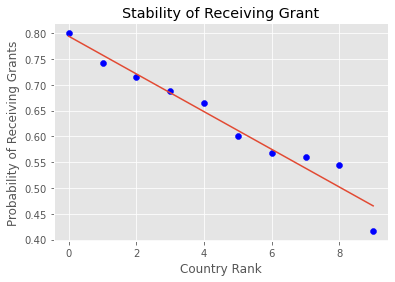

Country.of.Birth.1
The Americas              0.800000
Eastern Europe            0.741935
Middle East and Africa    0.714286
Australia                 0.687888
Asia Pacific              0.664122
South Africa              0.600000
Western Europe            0.567164
Great Britain             0.560976
North America             0.543860
New Zealand               0.416667
Name: SuccessfulGrant, dtype: float64
Slope: -0.03654167007424031


In [45]:
# Determine stability score for Applicants predicted to receive grants based on birth country

stab = test.groupby('Country.of.Birth.1')['SuccessfulGrant'].mean().sort_values(ascending=False)
counter = []

for i in range(test['Country.of.Birth.1'].nunique()):
    counter.append(i)

plt.scatter(counter, stab, color='blue')
plt.title('Stability of Receiving Grant')
plt.xlabel('Country Rank')
plt.ylabel('Probability of Receiving Grants')
plt.plot(np.unique(counter), np.poly1d(np.polyfit(counter, stab, 1))(np.unique(counter)))
plt.show()
print(stab)
print("Slope:", (np.polyfit(counter, stab, 1))[0])

Home.Language.1
English    0.660256
Other      0.666667
Name: SuccessfulGrant, dtype: float64


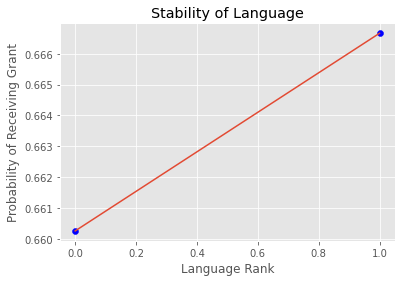

Slope: 0.0064102564102563875


In [46]:
# Determine stability score for overall applicants based on birth country

stab = test.groupby("Home.Language.1")['SuccessfulGrant'].mean()
counter = []

for i in range(test['Home.Language.1'].nunique()):
    counter.append(i)
print(stab)
plt.scatter(counter, stab, color='blue')
plt.title('Stability of Language')
plt.xlabel('Language Rank')
plt.ylabel('Probability of Receiving Grant')
plt.plot(np.unique(counter), np.poly1d(np.polyfit(counter, stab, 1))(np.unique(counter)))
plt.show()

print("Slope:", (np.polyfit(counter, stab, 1))[0])

We found that the slope of each plot was not steep enough to be considered stable. This means that small changes in the data would likely have a relatively large effect on the outcomes of the model, and therefore would easily change the ranking of the countries. Hence, we found that ‘Country.of.Birth’ and ‘Home.Language’ both were not robust to minimal changes within the data.

## Nutritional Label: Diversity
- The diversity widget of the nutritional label captures the diversity with respect to a set of categorical attributes, specifically Country of Birth and Home Language.
- Want to see if there were disparities between the diversity of applicants predicted a successful grant compared to the entire pool of applicants, based on these two categorical attributes.

In [47]:
vc = test['Country.of.Birth.1'].value_counts()
total = sum(vc)
total_aus = vc['Australia'] + vc['New Zealand']
total_aus / total

0.7357102433503112

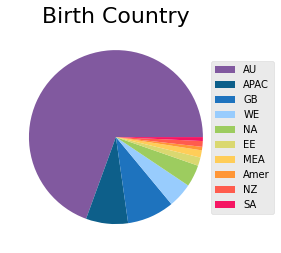

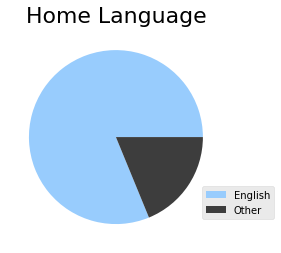

In [48]:
""" Determine diversty for Applicants predicted to receive grants """
# Based on BIRTH COUNTRY (proportion of positively predicted applicants born so and so)
total = test.groupby('Country.of.Birth.1')['GrantStatus'].mean().sort_values(ascending=False).sum()
countries = test.groupby('Country.of.Birth.1')['GrantStatus'].mean().sort_values(ascending=False)
value_counts =  test['Country.of.Birth.1'].value_counts().sort_values(ascending=False)
vals = []
chart_labels = ['New Zealand', 'South Africa', 'Great Britain', 'North America', 
                'Western Europe', 'Asia Pacific', 'Australia', 'Eastern Europe', 
                'Middle East and Africa', 'The Americas']
chart_colors = ['#81599F', '#0D5F8A', '#1E73BE', '#98CCFD', '#9DCC5F', 
                '#DAD870', '#FFCD58', '#FF9636', '#FF5C4D', '#F51663']
chart_abbr = ['AU', 'APAC', 'GB', 'WE', 'NA', 'EE', 'MEA', 'Amer', 'NZ', 'SA']

vals.append(value_counts[0] * countries[6])
vals.append(value_counts[1] * countries[5])
vals.append(value_counts[2] * countries[2])
vals.append(value_counts[3] * countries[4])
vals.append(value_counts[4] * countries[3])
vals.append(value_counts[5] * countries[7])
vals.append(value_counts[6] * countries[8])
vals.append(value_counts[7] * countries[9])
vals.append(value_counts[8] * countries[0])
vals.append(value_counts[9] * countries[1])

plt.pie(vals, colors=chart_colors)
plt.title("Birth Country", size=22)
plt.legend(chart_abbr, bbox_to_anchor=(1.25, 0.5), loc='right')
plt.show()


# Based on LANGUAGE (proportion of positively predicted applicants who speak English vs Other)
total = test.groupby('Home.Language.1')['GrantStatus'].mean().sort_values(ascending=False).sum()
languages = test.groupby('Home.Language.1')['GrantStatus'].mean().sort_values(ascending=False)
value_counts =  test['Home.Language.1'].value_counts().sort_values(ascending=False)
vals = []
chart_labels = ['English', 'Other']
chart_colors = ['#98CCFD', '#3d3d3d']
chart_abbr = ['English', 'Other']

vals.append(value_counts[0] * languages[0])
vals.append(value_counts[1] * languages[1])

plt.pie(vals, colors=chart_colors)
plt.title("Home Language", size=22)
plt.legend(chart_abbr, bbox_to_anchor=(1.25, 0.2), loc='right')
plt.show()

Index(['Australia', 'Asia Pacific', 'Great Britain', 'Western Europe',
       'North America', 'Eastern Europe', 'Middle East and Africa',
       'The Americas', 'New Zealand', 'South Africa'],
      dtype='object')


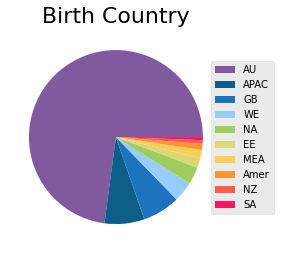

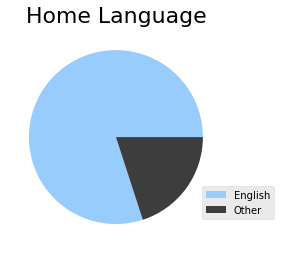

In [49]:
""" Determine diversity for Overall applicants """

# Based on BIRTH COUNTRY (proportion of applicants born so and so)
total = test['Country.of.Birth.1'].value_counts().sort_values(ascending=False).sum()
countries = test['Country.of.Birth.1'].value_counts().sort_values(ascending=False)
vals = []
chart_labels = countries.index
chart_colors = ['#81599F', '#0D5F8A', '#1E73BE', '#98CCFD', '#9DCC5F', 
                '#DAD870', '#FFCD58', '#FF9636', '#FF5C4D', '#F51663']
print(countries.index)
chart_abbr = ['AU', 'APAC', 'GB', 'WE', 'NA', 'EE', 'MEA', 'Amer', 'NZ', 'SA']

for i in range(len(countries)):
    vals.append( countries[i] / total)

plt.pie(vals, colors=chart_colors)
plt.title("Birth Country", size=22)
plt.legend(chart_abbr, bbox_to_anchor=(1.25, 0.5), loc='right')
plt.show()


# Based on LANGUAGE (proportion of applicants who speak English vs Other)
total = test['Home.Language.1'].value_counts().sort_values(ascending=False).sum()
languages = test['Home.Language.1'].value_counts().sort_values(ascending=False)
vals = []
chart_labels = ['English', 'Other']
chart_colors = ['#98CCFD', '#3d3d3d']

for i in range(len(languages)):
    vals.append( languages[i] / total)

plt.pie(vals, colors=chart_colors)
plt.title("Home Language", size=22)
plt.legend(chart_labels, bbox_to_anchor=(1.25, 0.2), loc='right')
plt.show()

Because these pie charts were nearly identical, it was clear that the model captured the diversity of applicants very well for both of different birth countries and native languages when it came to positively receiving a grant from the University of Melbourne.

## Nutritional Label: Disparate Impact and Statistical Parity (Fairness)
- The fairness widget quantified whether the outcomes exhibited disparate impact and statistical parity between groups with respect to the sensitive attributes. 
- Computed these metrics for both Country of Birth and Home Language attributes. 
- For Country of Birth, the privileged group was New Zealand/Australian (natives), and the unprivileged group was everyone else (non-natives). 
- For Home Language, the privileged group was English speakers, and the unprivileged group was other speakers.

In [50]:
""" Country """
print(test.groupby('NativeBirthCountry')['SuccessfulGrant'].mean())
total_c = sum(test['SuccessfulGrant'])
df_successful_outcome = test.query('SuccessfulGrant == 1')

# All instances of successful outcomes
num_c = df_successful_outcome['NativeBirthCountry'].value_counts()['Non-Native']
denom_c = df_successful_outcome['NativeBirthCountry'].value_counts()['Native']
print()
print("Total number of successful grants: ", total_c)
print("Number of successful grants belonging to unprivileged group:",num_c)
print("Number of successful grants belonging to privileged group: ",denom_c)
print("Disparate Impact: ", format((num_c/total_c) / (denom_c/total_c), ".4f"))

NativeBirthCountry
Native        0.685385
Non-Native    0.592466
Name: SuccessfulGrant, dtype: float64

Total number of successful grants:  1410
Number of successful grants belonging to unprivileged group: 519
Number of successful grants belonging to privileged group:  891
Disparate Impact:  0.5825


Disparate impact of 0.58 for native born (New Zealand and Australian) vs others when looking at successful grant applications.

In [51]:
# privileged probability - unprivileged probability
sp_c = (denom_c / total_c) - (num_c / total_c)
print("Statistical parity for Country of Birth: ", format(sp_c, ".4f"))

Statistical parity for Country of Birth:  0.2638


Statistical parity of 0.26 is relatively close to 0, indicating that there is some bias for applicants born in either Australia or New Zealand, but still relatively fair. 

In [52]:
""" Language """
print(test.groupby("Home.Language.1")['SuccessfulGrant'].mean().sort_values(ascending=False))
print()
lang = df_successful_outcome['Home.Language.1'].value_counts()
#34 english, 10 other
num_l = lang['Other']
den_l = lang['English']
tot_l = num_l + den_l

print("Total number of successful grants with a specified language: ",  tot_l)
print("Number Successful grants belonging to English speakers: ", den_l)
print("Number Successful grants belonging to non-English speakers: ", num_l)
print("Disparate Impact: ", (num_l / tot_l) / (den_l / tot_l))

Home.Language.1
Other      0.666667
English    0.660256
Name: SuccessfulGrant, dtype: float64

Total number of successful grants with a specified language:  129
Number Successful grants belonging to English speakers:  103
Number Successful grants belonging to non-English speakers:  26
Disparate Impact:  0.2524271844660194


Disparate impact of 0.25 for English speakers vs non-english speakers when looking at successful grant applications. 

In [53]:
sp_l = (den_l / tot_l) - (num_l / tot_l)
print("Statistical parity for native language: ", sp_l)

Statistical parity for native language:  0.5968992248062015


Statistical parity of 0.60 is not very close to 0. This indicates that there is bias for the privileged group. 